Policy Gradient (1 episode )

In [99]:
import torch
import torch.nn as nn
import gymnasium as gym 
import numpy as np 

import torch.optim as optim

from sklearn.preprocessing import StandardScaler

# distribution functions 
from torch.distributions import Categorical 

import sys
sys.path.append('../')


Define our Policy 

In [100]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Policy, self).__init__()

        self.fnn = nn.Sequential(
            nn.Linear(state_dim, 16),
            nn.ReLU(),
            nn.Linear(16, action_dim),
            nn.Softmax()
        )

        # storing the log probability distribution
        self.log_probabilities = []
        
        # storing the rewards for each step
        self.rewards = []

    def reset(self):
        """ Internal reset """
        self.log_probabilities = []
        self.rewards = []

    def forward(self, state):
        action_logits = self.fnn(state)

        return action_logits
    
    def tensor(self, obs):
        return torch.FloatTensor(obs)
    
    @torch.no_grad()
    def predict(self, obs):
        obs_tensor = self.tensor(obs)
        probs = self.fnn(obs_tensor)
        action = torch.argmax(probs).item()
        return action

    def generate_q_table(self, usable_ace=False, start_pos=5):
        """Generate a tabular Q-value dict for plotting."""
        self.q_values = {}
        for player_sum in range(start_pos, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                state_tensor = self.tensor(state)
                q_vals = self.predict(state_tensor)
                self.q_values[state] = q_vals

In [106]:
env = gym.make("Blackjack-v1")

# policy initializations 
policy = Policy(3, 2)

optimizer = optim.Adam(policy.parameters(),lr=0.00005)

losses = []
best_reward = -np.inf 
avg_reward= 0

gamma = 0.85
break_counter = 0
epoches = 50_000
episode_rewards = []  
avg_rewards = []

hit_probability = []
stick_probability = []

for e in range(epoches):
    
    termination = False 
    
    if break_counter >= 7_000:
        break

    # sample 1 episode 
    obs = env.reset()[0]

    while not termination:

        # sample a action from the probability distribution 
        state_tensors = torch.FloatTensor(obs)
        action_tensors = policy(state_tensors)

        # logging hit or stick 
        h, s = action_tensors[0].item(), action_tensors[1].item() 
        hit_probability.append(h)
        stick_probability.append(s)

        # Create a distribution based on the probability from the softmax layer
        distribution = Categorical(action_tensors)

        # stohastic sampling 
        action = distribution.sample()

        # log * π(A|S)
        log_probabilities = distribution.log_prob(action)

        obs, reward, termination, truncation, info = env.step(action.item())
        
        # record the rewards 
        policy.rewards.append(reward)

        # storing the log probabilities
        policy.log_probabilities.append(log_probabilities)

    # print('Finished one episode....computing rewards and gradients now...')

    """
    paramter updates = parameter updates + stepping sizes * sum(log_probabilities * Gt)

    1st step: calculate the Gt at each iteration 
    Gt = Imeddiate reward + future reward * gamma
    """

    discounted_rewards = []
    R = 0
    for r in reversed(policy.rewards):
        R = r + gamma * R
        discounted_rewards.append(R)

    discounted_rewards = list(reversed(discounted_rewards))
    advantage = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9)
    advantage = torch.tensor(advantage)

    loss = []
    for log_prob, G in zip(policy.log_probabilities, advantage):

        # -negative here because gradient descent moves backwards in pytorch
        # here we are trying to maximize so we can simply flip the signs 
        loss.append(-log_prob * G)

    # entropy = distribution.entropy()
    policy_loss = torch.stack(loss, dim=0).sum() 
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    episode_reward = sum(policy.rewards)
    episode_rewards.append(episode_reward)

    if e > 100:
        avg_reward = np.mean(episode_rewards[-100:])
        avg_rewards.append(avg_reward)
        print(f"Episode {e} | Avg Reward (last 100): {avg_reward:.2f}")

    if avg_reward > best_reward and e > 100:
        best_reward = avg_reward
        torch.save(policy, '../checkpoints/policy_gradient_1_episode.pth')

    else:
        break_counter += 1
  
    # reset the internal state for the next episode 
    policy.reset()

Episode 101 | Avg Reward (last 100): -0.30
Episode 102 | Avg Reward (last 100): -0.32
Episode 103 | Avg Reward (last 100): -0.34
Episode 104 | Avg Reward (last 100): -0.34
Episode 105 | Avg Reward (last 100): -0.34
Episode 106 | Avg Reward (last 100): -0.36
Episode 107 | Avg Reward (last 100): -0.37
Episode 108 | Avg Reward (last 100): -0.36
Episode 109 | Avg Reward (last 100): -0.38
Episode 110 | Avg Reward (last 100): -0.38
Episode 111 | Avg Reward (last 100): -0.39
Episode 112 | Avg Reward (last 100): -0.39
Episode 113 | Avg Reward (last 100): -0.41
Episode 114 | Avg Reward (last 100): -0.41
Episode 115 | Avg Reward (last 100): -0.39
Episode 116 | Avg Reward (last 100): -0.41
Episode 117 | Avg Reward (last 100): -0.41
Episode 118 | Avg Reward (last 100): -0.41
Episode 119 | Avg Reward (last 100): -0.41
Episode 120 | Avg Reward (last 100): -0.41
Episode 121 | Avg Reward (last 100): -0.40
Episode 122 | Avg Reward (last 100): -0.40
Episode 123 | Avg Reward (last 100): -0.40
Episode 124

Black Jack is pretty hard to beat..and PG with 1 episodic MC can fall in a bad route.....

Good Example

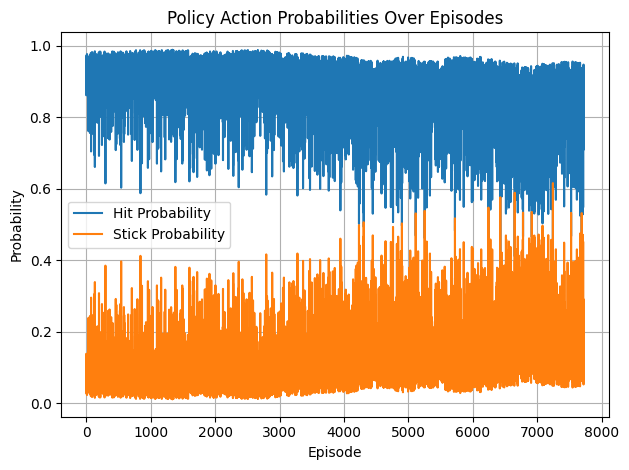

In [107]:
import matplotlib.pyplot as plt

# Example data — replace with your real lists
episodes = list(range(len(hit_probability)))

# Plot both
plt.plot(episodes, hit_probability, label='Hit Probability')
plt.plot(episodes, stick_probability, label='Stick Probability')

# Add labels and legend
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.title('Policy Action Probabilities Over Episodes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


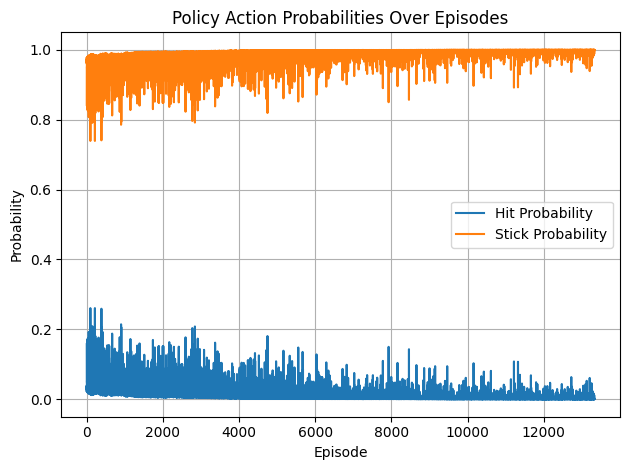

In [ ]:

import matplotlib.pyplot as plt

# Example data — replace with your real lists
episodes = list(range(len(hit_probability)))

# Plot both
plt.plot(episodes, hit_probability, label='Hit Probability')
plt.plot(episodes, stick_probability, label='Stick Probability')

# Add labels and legend
plt.xlabel('Episode')
plt.ylabel('Probability')
plt.title('Policy Action Probabilities Over Episodes ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Bad Example

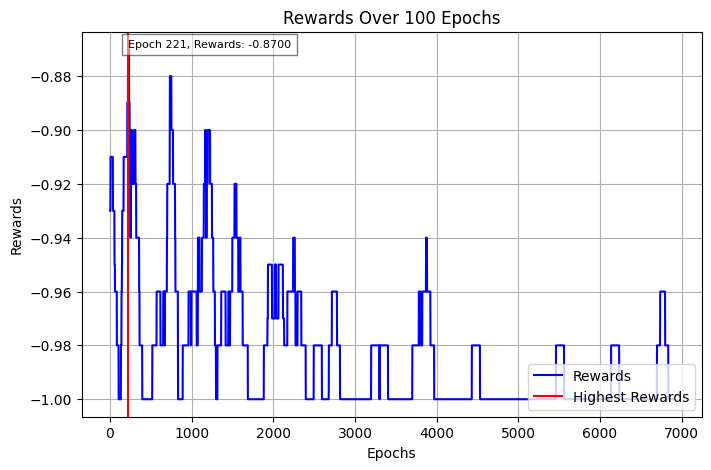

In [103]:
import matplotlib.pyplot as plt

# Ensure both lists have the same length
epochs = list(range(1, len(avg_rewards) + 1))

# Find min loss points
min_train_index = avg_rewards.index(max(avg_rewards))

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(avg_rewards, label="Rewards", linestyle='-', color='blue')

# Add vertical lines at minimum loss points
plt.axvline(x=min_train_index, color='red', linestyle='-', label='Highest Rewards')

# Add text labels at min loss points
plt.text(min_train_index, max(avg_rewards), 
         f'Epoch {min_train_index}, Rewards: {max(avg_rewards):.4f}', 
         ha='left', va='bottom', fontsize=8, 
         bbox={'facecolor': 'white', 'alpha': 0.5})

# Labels, legend, and grid
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.title("Rewards Over 100 Epochs")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


Good Example

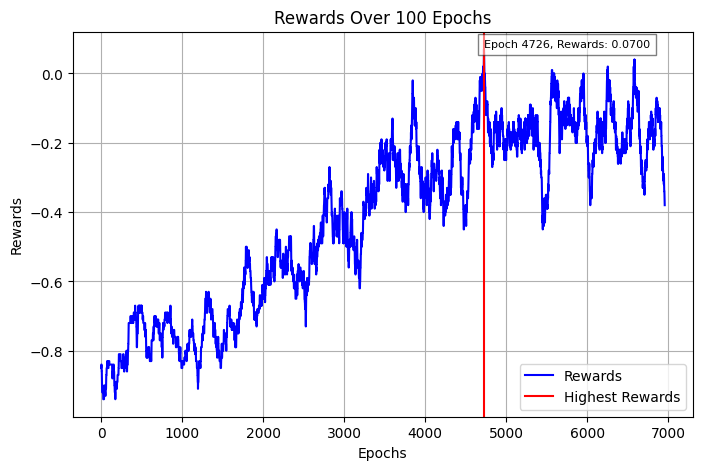

In [ ]:
import matplotlib.pyplot as plt

# Ensure both lists have the same length
epochs = list(range(1, len(avg_rewards) + 1))

# Find min loss points
min_train_index = avg_rewards.index(max(avg_rewards))

# Plot the losses
plt.figure(figsize=(8, 5))
plt.plot(avg_rewards, label="Rewards", linestyle='-', color='blue')

# Add vertical lines at minimum loss points
plt.axvline(x=min_train_index, color='red', linestyle='-', label='Highest Rewards')

# Add text labels at min loss points
plt.text(min_train_index, max(avg_rewards), 
         f'Epoch {min_train_index}, Rewards: {max(avg_rewards):.4f}', 
         ha='left', va='bottom', fontsize=8, 
         bbox={'facecolor': 'white', 'alpha': 0.5})

# Labels, legend, and grid
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.title("Rewards Over 100 Epochs")
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
from modules.utils import * 

best_policy = torch.load('../checkpoints/policy_gradient_1_episode.pth')
best_policy.generate_q_table(usable_ace=True, start_pos=5)

C:\Users\Stevie\AppData\Local\Temp\ipykernel_13228\3940262419.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_policy = torch.load('../checkpoints/policy_gradient_1_

Policy Gradient is still a Monte Carlo because we require it to complete a full episode.
Blackjack usually ends within 5 hits... so the time complexity and computational cost isn't is high
The volailtility is not as high...

In [ ]:
from collections import defaultdict
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

def create_grids(agent, usable_ace=False, starting_pos=12):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = action_values
        policy[obs] = action_values

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(starting_pos, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid
    

def create_plots(value_grid, policy_grid, title: str, starting_pos=12):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(starting_pos, 22), range(starting_pos, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(starting_pos, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


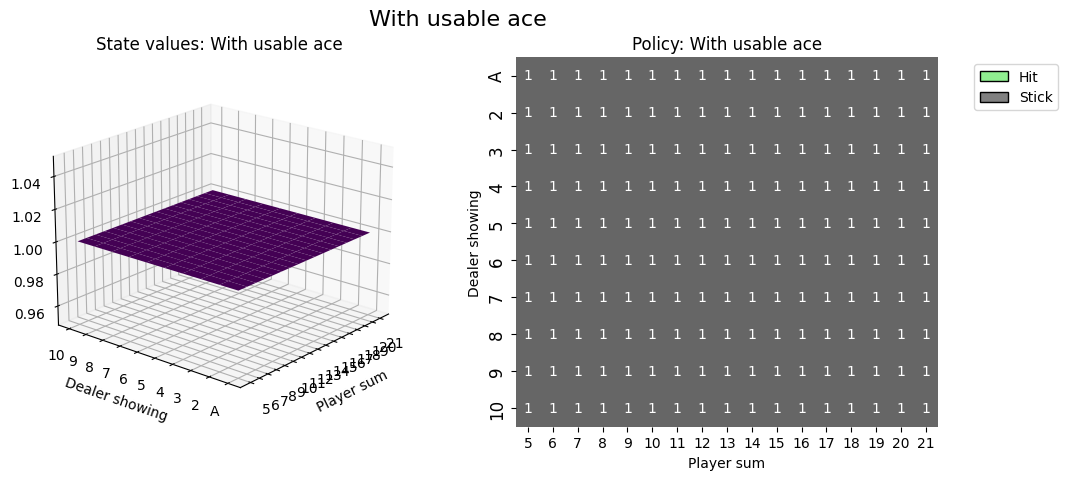

In [ ]:
best_policy.generate_q_table(usable_ace=True, start_pos=5)
value_grid, policy_grid = create_grids(best_policy, usable_ace=True, starting_pos=5)
fig = create_plots(value_grid, policy_grid, title="With usable ace", starting_pos=5)
plt.show()

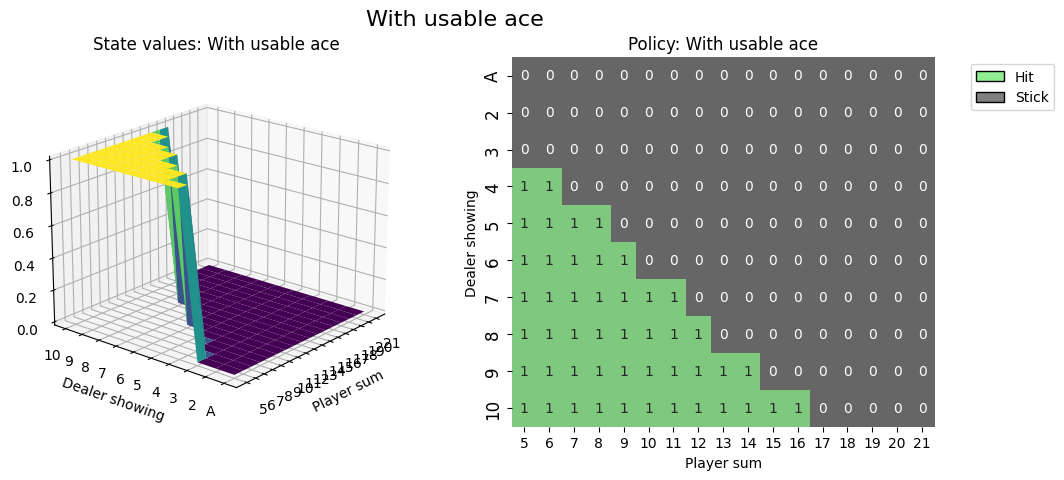

In [ ]:
best_policy.generate_q_table(usable_ace=True, start_pos=5)
value_grid, policy_grid = create_grids(best_policy, usable_ace=True, starting_pos=5)
fig = create_plots(value_grid, policy_grid, title="With usable ace", starting_pos=5)
plt.show()

12 and onwards

So it seems it is sticking too early, reaching to local minima? 

If random episodes found that sticking leads to less frequent bust, it might just stay oh might as well stick always? 

The flat reward landscape.

DQN uses existing value estimates isnstead of waiting for full returns.

In [ ]:
basic_strategy_grid = np.array([
    [1, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # Dealer shows Ace
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 2
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 3
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 4
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 5
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],  # Dealer shows 6
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 7
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 8
    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # Dealer shows 9
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],  # Dealer shows 10
])
best_policy.generate_q_table(usable_ace=True, start_pos=12)
value_grid, policy_grid = create_grids(best_policy, usable_ace=True, starting_pos=12)

coverage = policy_grid == basic_strategy_grid
coverage_pcnt = np.sum(coverage) / coverage.size * 100
print(f"Policy matches basic strategy on {np.sum(coverage)}/{coverage.size} cells")
print(f"Coverage: {coverage_pcnt:.2f}%")

Policy matches basic strategy on 58/100 cells
Coverage: 58.00%


c:\Users\Stevie\python\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


***